# Imports

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchmetrics
import random

# Making dataset from data

#### Define PyTorch dataset class

In [31]:
class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Create a list of all image paths and their corresponding labels
        self.image_paths = []
        self.labels = []

        # Load the CSV file into a DataFrame
        df = pd.read_csv(csv_file)

        # Create a mapping of unique diseases to integer labels
        self.label_map = {disease: idx for idx, disease in enumerate(df['type'].unique())}

        for index, row in df.iterrows():
            # Only consider .jpg files
            if row['jpg'].endswith('.jpg'):
                self.image_paths.append(os.path.join(root_dir, 'files', row['jpg'][1:]))  # [1:] to skip the initial '/'
                self.labels.append(self.label_map[row['type']])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

#### Define data transformation

In [32]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit models like ResNet, etc.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Imagenet norms
])


#### Instantiate dataset class

In [33]:
dataset = ChestXRayDataset(
    root_dir='C:/Users/Michal/Desktop/AI_ML/Chest_X_ray_Kaggle/data',
    csv_file='C:/Users/Michal/Desktop/AI_ML/Chest_X_ray_Kaggle/data/xray_chest.csv',
    transform=data_transform
)

print(len(dataset))



97


#### Spliting dataset into train and test sets

In [34]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#### Create data loaders

In [35]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Class list

In [36]:
class_list = list(dataset.label_map.keys())
class_list

['abscess',
 'ards',
 'atelectasis',
 'atherosclerosis of the aorta',
 'cardiomegaly',
 'emphysema',
 'fracture',
 'hydropneumothorax',
 'hydrothorax',
 'pneumonia',
 'pneumosclerosis',
 'post-inflammatory changes',
 'post-traumatic ribs deformation',
 'sarcoidosis',
 'scoliosis',
 'tuberculosis',
 'venous congestion']

# Visualizing data

#### Visualising function

In [37]:
def imshow_grid(images, labels, label_map):
    """Display a grid of images with labels."""
    n = len(images)  # number of images
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5)
    
    for i, ax in enumerate(axs.ravel()):
        if i < n:
            image = images[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)
            ax.imshow(image)
            ax.set_title(label_map[labels[i]])
            ax.axis('off')
        else:
            # If there's no image for this position in the grid, turn off axis
            ax.axis('off')
    
    plt.show()


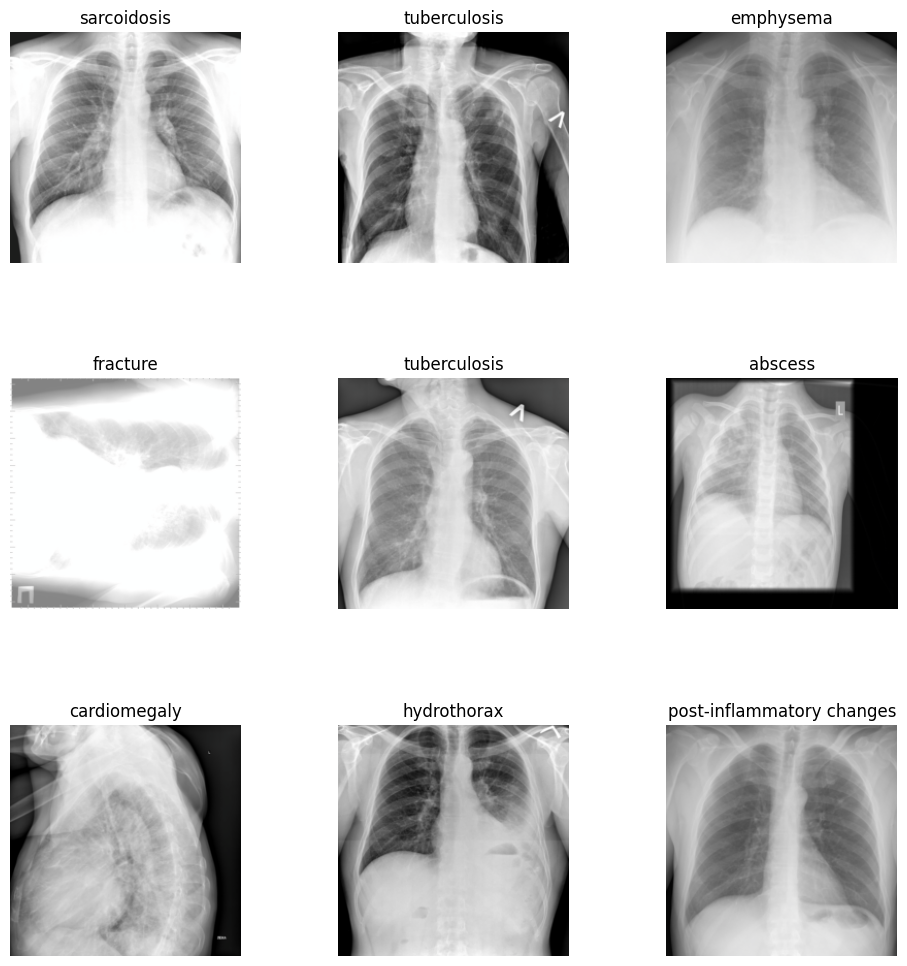

In [38]:
# Get a random batch of images
dataiter = iter(DataLoader(dataset, batch_size=9, shuffle=True))
images, labels = next(dataiter)

# Show images in a grid
imshow_grid(images, labels.numpy(), class_list)


# Model

In [39]:
class SimpleCNN(nn.Module):
    
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


#### Device agnostic code

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#### Instantiate model

In [41]:
import os

model_path = 'C:/Users/Michal/Desktop/AI_ML/Chest_X_ray_Kaggle/model.pth'

# Check if the model file exists
if os.path.exists(model_path):
    # Load the existing model
    model = SimpleCNN(num_classes=len(class_list))
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    print("Model loaded from", model_path)
else:
    # Instantiate a new model
    model = SimpleCNN(num_classes=len(class_list))
    model.to(device)
    print("New model instantiated")

Model loaded from C:/Users/Michal/Desktop/AI_ML/Chest_X_ray_Kaggle/model.pth


# Training loop

#### Define data augmentation transformations

In [42]:
def random_transforms():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

#### Hyperparameters

In [43]:
lr = 0.001
epochs = 100
batch_size = 8

#### Define loss function, optimizer and accuracy metric

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
accuracy_fn = torchmetrics.classification.MulticlassAccuracy(num_classes = len(class_list))

#### Training loop 

In [45]:
best_test_acc = 0.0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}\n-------------------------------')
    
    train_dataset.transform = random_transforms()
    transformed_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    model_train_loss = 0
    model_train_acc = 0

    for inputs, labels in transformed_train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        model_train_loss += loss.item()
        model_train_acc += accuracy_fn(torch.argmax(outputs, dim=1), labels)
    
    model_train_loss /= len(transformed_train_loader)
    model_train_acc /= len(transformed_train_loader)
    if epoch % 10 == 0:
        print(f'Training loss: {model_train_loss:.4f}, Training accuracy: {model_train_acc:.4f}')

    model.eval()
    
    model_test_loss = 0
    model_test_acc = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            model_test_loss += loss.item()
            model_test_acc += accuracy_fn(torch.argmax(outputs, dim=1), labels)

    model_test_loss /= len(test_loader)
    model_test_acc = model_test_acc / len(test_loader)

    print(f'Testing loss: {model_test_loss:.4f}, Testing accuracy: {model_test_acc:.4f}\n')

    if model_test_acc > best_test_acc:
        best_test_acc = model_test_acc
        torch.save(model.state_dict(), 'C:/Users/Michal/Desktop/AI_ML/Chest_X_ray_Kaggle/model.pth')
        print(f'Model saved with accuracy: {best_test_acc:.4f}')

Epoch 1/100
-------------------------------


Training loss: 1.6645, Training accuracy: 0.3348
Testing loss: 0.3899, Testing accuracy: 0.9583

Model saved with accuracy: 0.9583
Epoch 2/100
-------------------------------
Testing loss: 0.4795, Testing accuracy: 0.8889

Epoch 3/100
-------------------------------
Testing loss: 0.6964, Testing accuracy: 0.7593

Epoch 4/100
-------------------------------
Testing loss: 0.6920, Testing accuracy: 0.8056

Epoch 5/100
-------------------------------
Testing loss: 0.7941, Testing accuracy: 0.6746

Epoch 6/100
-------------------------------
Testing loss: 0.7751, Testing accuracy: 0.7685

Epoch 7/100
-------------------------------
Testing loss: 0.8812, Testing accuracy: 0.5722

Epoch 8/100
-------------------------------
Testing loss: 0.8079, Testing accuracy: 0.7639

Epoch 9/100
-------------------------------
Testing loss: 0.7432, Testing accuracy: 0.6250

Epoch 10/100
-------------------------------
Testing loss: 0.6066, Testing accuracy: 0.7778

Epoch 11/100
---------------------------

# Evaluating the model

#### Making predictions

In [46]:
model.eval()

all_images = []
all_labels = []
all_predictions = []

with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)

        all_images.extend(inputs.cpu())
        all_labels.extend(labels.cpu())
        all_predictions.extend(predictions.cpu())

accuracy = accuracy_fn(torch.tensor(all_predictions), torch.tensor(all_labels))
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.4643


#### Taking random sample

In [47]:
selected_indices = random.sample(range(len(all_images)), 9)
selected_images = [all_images[i] for i in selected_indices]
selected_labels = [all_labels[i] for i in selected_indices]
selected_predictions = [all_predictions[i] for i in selected_indices]

#### Visualizing predictions

In [48]:
index_to_class = {v: k for k, v in dataset.label_map.items()}

def visualize_predictions(images, labels, predictions, label_map):
    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.ravel()  # Flatten the axes array for easier iteration
    
    for i in range(rows * cols):
        if i < num_images:
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            img = np.clip(img, 0, 1)
            axs[i].imshow(img)
            
            true_label = index_to_class[labels[i].item()]
            pred_label = index_to_class[predictions[i].item()]
            
            color = 'green' if true_label == pred_label else 'red'
            axs[i].set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
        axs[i].axis('off')
    
    plt.show()

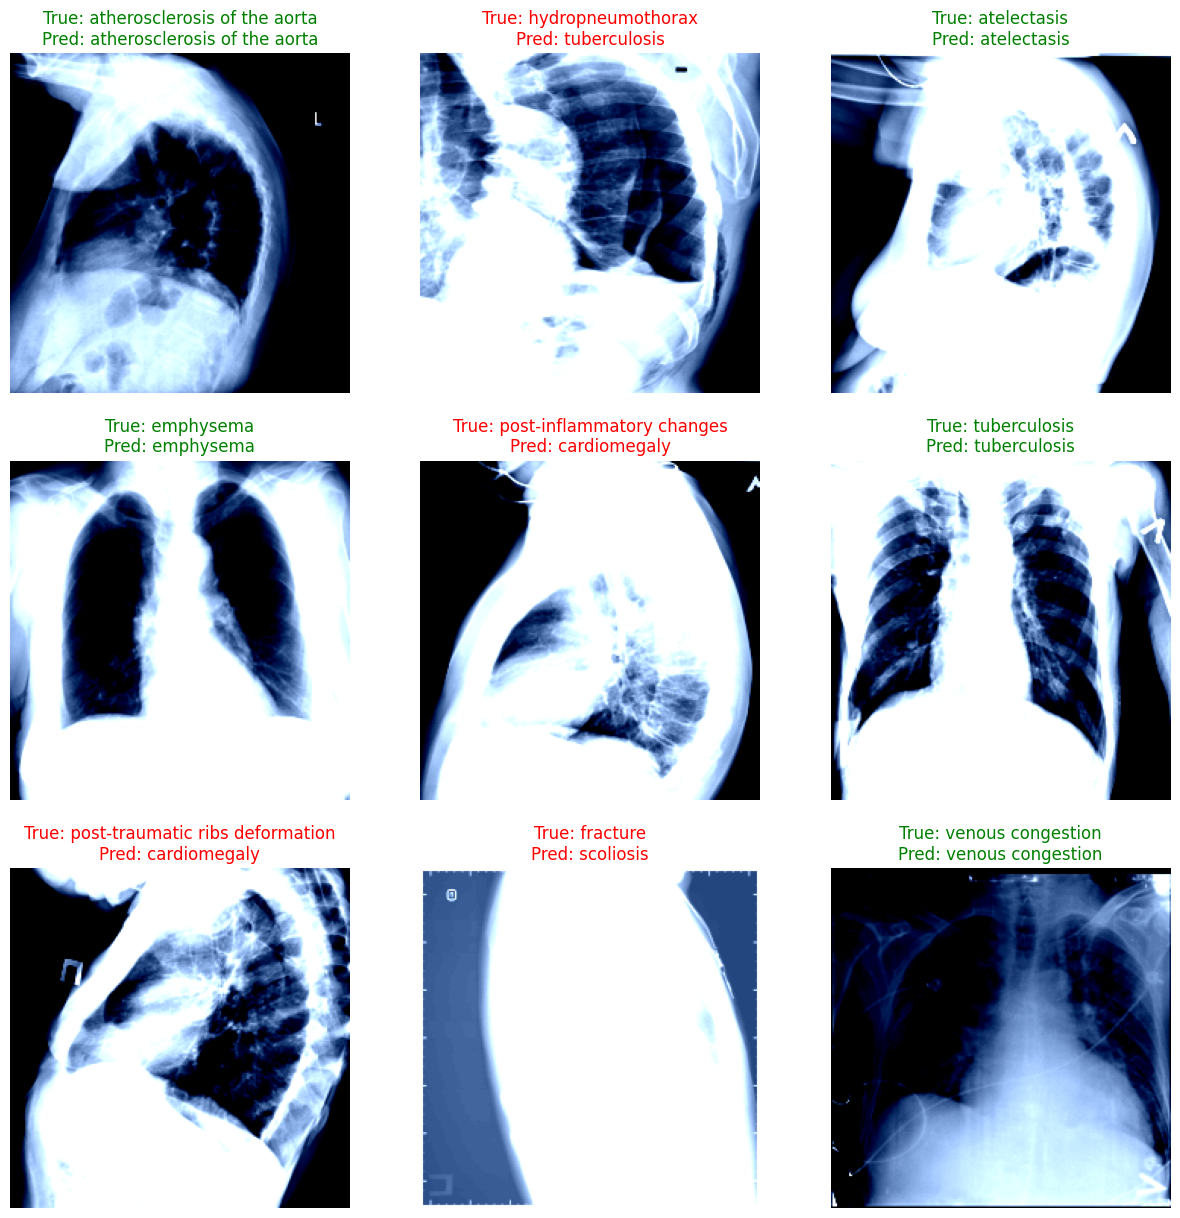

In [49]:
visualize_predictions(selected_images, selected_labels, selected_predictions, dataset.label_map)